### Installation

In [1]:
#!pip install git+https://www.github.com/huggingface/transformers
#!pip install git+https://github.com/huggingface/accelerate
#!pip install bitsandbytes
#!pip install einops
#!pip install --upgrade torch torchvision
#!pip install scikit-learn
#!pip install matplotlib
#!pip install datasets
#!pip install Bio
#!pip install pybedtools
#!pip install tabulate

## Paths & CKPT

In [2]:
import os

# mpra
dataset_path = "/data/Dcode/gaetano/repos/Transformers4Genomic/data/mpra/GSE68331_SNP.csv"
path_models = "/data/Dcode/gaetano/models_comparisons/"

# model name from huggingface.co/model name_id:model_name
type_model = '_ft_Hepg2_1kbpHG19_DHSs_H3K27AC'

# get models 
models_names = [item+type_model for item in os.listdir(path_models) if os.path.isdir(path_models+item)]

# get predictions
path_predictions = ".."

FASTA_FILE_19 = "/data/Dcode/gaetano/repos/Transformers4Genomic/data/hg19.fa"
FASTA_FILE_38 = "/data/Dcode/gaetano/repos/Transformers4Genomic/data/hg38.fa"

### remove hyenadna

In [3]:
models_names = [model for model in models_names if not model.startswith('hyenadna')]
models_names

['DNABERT-2-117M_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'Geneformer_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'gena-lm-bert-base-t2t_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'gena-lm-bert-large-t2t_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'gena-lm-bigbird-base-t2t_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'nucleotide-transformer-2.5b-1000g_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'nucleotide-transformer-2.5b-multi-species_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'nucleotide-transformer-500m-1000g_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'nucleotide-transformer-500m-human-ref_ft_Hepg2_1kbpHG19_DHSs_H3K27AC']

## Libraries

In [4]:
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoModel
from transformers.models.bert.configuration_bert import BertConfig
from datasets import load_dataset, Dataset

from sklearn import metrics 
from sklearn.model_selection import train_test_split

from Bio import SeqIO
from pybedtools import BedTool

import pandas as pd
import numpy as np
import scipy.stats as stats

import torch
from torch import nn

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

2024-09-16 14:56:32.447314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 14:56:32.465471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 14:56:32.465498: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 14:56:32.477131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 14:56:35.186086: W tensorflow/compiler/tf

## Load Transformer Models

In [5]:
models_tokenizers_dict = {}

for model_ckpt in models_names:
    
    # load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained('tanoManzo/'+model_ckpt, trust_remote_code=True) 
    model = AutoModelForSequenceClassification.from_pretrained('tanoManzo/'+model_ckpt)

    models_tokenizers_dict[model_ckpt] = {'model':model , 'tokenizer':tokenizer}

Some weights of the model checkpoint at tanoManzo/gena-lm-bert-base-t2t_ft_Hepg2_1kbpHG19_DHSs_H3K27AC were not used when initializing BertForSequenceClassification: ['bert.encoder.layer.0.post_attention_ln.bias', 'bert.encoder.layer.0.post_attention_ln.weight', 'bert.encoder.layer.0.pre_attention_ln.bias', 'bert.encoder.layer.0.pre_attention_ln.weight', 'bert.encoder.layer.1.post_attention_ln.bias', 'bert.encoder.layer.1.post_attention_ln.weight', 'bert.encoder.layer.1.pre_attention_ln.bias', 'bert.encoder.layer.1.pre_attention_ln.weight', 'bert.encoder.layer.10.post_attention_ln.bias', 'bert.encoder.layer.10.post_attention_ln.weight', 'bert.encoder.layer.10.pre_attention_ln.bias', 'bert.encoder.layer.10.pre_attention_ln.weight', 'bert.encoder.layer.11.post_attention_ln.bias', 'bert.encoder.layer.11.post_attention_ln.weight', 'bert.encoder.layer.11.pre_attention_ln.bias', 'bert.encoder.layer.11.pre_attention_ln.weight', 'bert.encoder.layer.2.post_attention_ln.bias', 'bert.encoder.laye

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
!gpustat

cn2895                    Mon Sep 16 14:57:03 2024  535.129.03
[0] NVIDIA A100-SXM4-80GB | 35°C,   0 % |     4 / 81920 MB |


## Datasetes

### get fasta hg19/hg38 database

In [7]:
def get_chrom2seq(capitalize=True):

    chrom2seq = {}
    for seq in SeqIO.parse(FASTA_FILE_19, "fasta"):
        chrom2seq[seq.description.split()[0]] = seq.seq.upper() if capitalize else seq.seq

    return chrom2seq

chrom2seq = get_chrom2seq()

### Get MPRA data

In [8]:
import os
import pandas as pd

# data path
mpra_df = pd.read_csv(dataset_path)
mpra_df.head(10)


,id,chr3,Pos,Allele0,dna0,rna0,Allele1,dna1,rna1,P,effect,MAF (Capture),MAF (POP-STARR),Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,.,chr3,156781891,T,151,158,C,10,22.0,0.256182,2.102532,0.005263,0.062112,NaN,NaN,NaN,NaN
1,rs142569593,chr3,156782952,A,1,6,G,1161,2590.0,0.867796,0.372380,0.005263,0.000861,NaN,NaN,NaN,NaN
2,.,chr3,156788557,A,169,1392,G,5341,43600.0,0.986614,0.990245,0.005263,0.030672,NaN,NaN,NaN,NaN
3,rs73170826,chr3,156793907,T,6,47,C,1697,7510.0,0.520927,0.564576,0.005263,0.003523,NaN,NaN,NaN,NaN
4,rs141309976,chr3,156795268,T,15,109,C,3784,36200.0,0.655687,1.314977,0.005263,0.003948,NaN,NaN,NaN,NaN
5,rs145204171,chr3,156799432,A,266,1834,G,5824,37600.0,0.655687,0.936223,0.005263,0.043678,NaN,NaN,NaN,NaN
6,.,chr3,156800347,C,22096,336271,G,723,9780.0,0.028130,0.888933,0.005263,0.031684,NaN,NaN,NaN,NaN
7,.,chr3,156801110,T,3488,12594,C,25,104.0,0.830161,1.152142,0.005263,0.007116,NaN,NaN,NaN,NaN
8,.,chr3,156806197,A,950,3873,G,44,218.0,0.599938,1.215290,0.005263,0.044266,NaN,NaN,NaN,NaN
9,rs187206450,chr3,156806296,A,979,4035,G,15,56.0,0.895032,0.905808,0.005263,0.015091,NaN,NaN,NaN,NaN


### Extract Sequences

In [9]:
def process_sequences(mpra_df, chrom2seq, length_bp=999):
    """
    Process sequences from a DataFrame and extract reference and alternative sequences.

    Parameters:
        mpra_df (pd.DataFrame): DataFrame containing chromosome, position, alt, and p-value columns.
        chrom2seq (dict): Dictionary mapping chromosomes to sequence data.
        length_bp (int): Length of the sequence to extract centered around each position.

    Returns:
        tuple: A tuple containing three lists:
            - seq_ref (list): List of reference sequences.
            - seq_alt (list): List of alternative sequences.
            - seq_val (list): List of values.
    """
    seq_ref = []
    seq_alt = []
    seq_val = []

    # Iterate over the DataFrame rows
    for idx, row in mpra_df.iterrows():
        chromosome = f"{row['chr3']}"
        abspos = row['Pos']
        
        # Calculate the start and end positions for the sequence extraction
        start_pos = abspos - (length_bp // 2)-1
        end_pos = abspos + (length_bp // 2)  # Add 1 to ensure the length is exactly 1000 bp
        
        # Extract the sequence from the chromosome data
        seq = str(chrom2seq[chromosome][start_pos:end_pos])
        if len(seq) != length_bp:
            raise ValueError(f"Extracted sequence length {len(seq)} does not match the expected length {length_bp}.")
        
        half_len = len(seq) // 2
        #seq_ref.append(seq)
        seq_ref.append(f"{seq[:half_len]}{row['Allele0']}{seq[half_len + 1:]}")
        
        # Create the alternative sequence by replacing the middle base with 'Alt'
        seq_alt.append(f"{seq[:half_len]}{row['Allele1']}{seq[half_len + 1:]}")
        
        # Append the value from the DataFrame
        seq_val.append(row['effect'])
        
    return seq_ref, seq_alt, seq_val

seq_ref, seq_alt, seq_val = process_sequences(mpra_df, chrom2seq)
seq_val_p = -np.log10(mpra_df['P'])*np.sign((mpra_df['rna1']/mpra_df['dna1'])-(mpra_df['rna0']/mpra_df['dna0']))
#seq_val_real = (mpra_df['rnaMin']/mpra_df['dnaMin'])/(mpra_df['rnaMaj']/mpra_df['dnaMaj'])

In [11]:
# Define the significance threshold for filtering
p_value_threshold = 0.05

# Create a boolean mask for filtering
filter_significant = mpra_df['P'] < p_value_threshold

# Apply the mask to filter the DataFrame
mpra_df_filtered = mpra_df[filter_significant]

seq_ref_filtered, seq_alt_filtered, seq_val_filtered = process_sequences(mpra_df_filtered, chrom2seq, length_bp=999)
mpra_df_filtered

,id,chr3,Pos,Allele0,dna0,rna0,Allele1,dna1,rna1,P,effect,MAF (Capture),MAF (POP-STARR),Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
6,.,chr3,156800347,C,22096,336271,G,723,9780.0,2.812957e-02,0.888933,0.005263,0.031684,NaN,NaN,NaN,NaN
23,rs374940809,chr3,156828560,T,1302,1849,C,38,92.0,4.848807e-02,1.704819,0.005263,0.028358,NaN,NaN,NaN,NaN
28,.,chr3,156838396,T,628,18973,C,2396,57285.0,4.091370e-06,0.791367,0.005263,0.207672,NaN,NaN,NaN,NaN
38,rs117360271,chr3,156852314,T,814,17851,G,11387,195495.0,5.062570e-10,0.782867,0.005263,0.066716,NaN,NaN,NaN,NaN
40,.,chr3,156853347,T,79,679,C,1268,7782.0,4.334203e-02,0.714051,0.005263,0.058649,NaN,NaN,NaN,NaN
43,rs192145568,chr3,156854829,A,201,1856,C,13819,183069.0,7.360760e-05,1.434684,0.005263,0.014337,NaN,NaN,NaN,NaN
51,.,chr3,156878129,T,27,472,C,9915,309336.0,4.848807e-02,1.784677,0.005263,0.002716,NaN,NaN,NaN,NaN
62,.,chr3,156898385,A,16656,124994,G,1157,9901.0,5.041140e-04,1.140321,0.005263,0.064953,NaN,NaN,NaN,NaN
78,rs180685260,chr3,157000353,A,1471,11094,G,14766,101131.0,1.013039e-02,0.908126,0.005263,0.090596,NaN,NaN,NaN,NaN
88,rs150111201,chr3,156800112,A,13187,144329,G,4492,56947.0,8.807240e-15,1.158307,0.010526,0.254087,NaN,NaN,NaN,NaN


## Evaluation 

### Get model predictions

In [13]:
import torch

# Function to get predictions in batches
def get_predictions_raw(models_tokenizers_dict, seq_ref, seq_alt, device="cuda", batch_size=32):
    models_predictions = {}

    def tokenize_in_batches(sequence, tokenizer, max_length=512, batch_size=32):
        tokens = tokenizer(sequence, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        for i in range(0, tokens['input_ids'].size(0), batch_size):
            yield {k: v[i:i+batch_size].to(device) for k, v in tokens.items()}

    for model_name, item in models_tokenizers_dict.items():
        model = item['model'].to(device).eval()
        tokenizer = item['tokenizer']

        print(f"Processing model: {model_name}")

        outputs_ref = []
        outputs_alt = []

        # Process in batches
        for inputs_ref in tokenize_in_batches(seq_ref, tokenizer, batch_size=batch_size):
            with torch.no_grad():
                batch_outputs_ref = model(**inputs_ref).logits.cpu()
                outputs_ref.append(batch_outputs_ref)
            torch.cuda.empty_cache()  # Clear memory after each batch

        for inputs_alt in tokenize_in_batches(seq_alt, tokenizer, batch_size=batch_size):
            with torch.no_grad():
                batch_outputs_alt = model(**inputs_alt).logits.cpu()
                outputs_alt.append(batch_outputs_alt)
            torch.cuda.empty_cache()  # Clear memory after each batch

        # Concatenate all batch results
        outputs_ref = torch.cat(outputs_ref, dim=0)
        outputs_alt = torch.cat(outputs_alt, dim=0)

        # Store results in CPU memory
        models_predictions[model_name] = {'ref': outputs_ref, 'alt': outputs_alt}

        # Free GPU memory by moving model to CPU and clearing cache
        model.to("cpu")
        torch.cuda.empty_cache()

    return models_predictions

# Usage
models_predictions = get_predictions_raw(models_tokenizers_dict, seq_ref, seq_alt, batch_size=8)


Processing model: DNABERT-2-117M_ft_Hepg2_1kbpHG19_DHSs_H3K27AC
Processing model: Geneformer_ft_Hepg2_1kbpHG19_DHSs_H3K27AC
Processing model: gena-lm-bert-base-t2t_ft_Hepg2_1kbpHG19_DHSs_H3K27AC
Processing model: gena-lm-bert-large-t2t_ft_Hepg2_1kbpHG19_DHSs_H3K27AC


Attention type 'block_sparse' is not possible if sequence_length: 183 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Processing model: gena-lm-bigbird-base-t2t_ft_Hepg2_1kbpHG19_DHSs_H3K27AC
Processing model: nucleotide-transformer-2.5b-1000g_ft_Hepg2_1kbpHG19_DHSs_H3K27AC
Processing model: nucleotide-transformer-2.5b-multi-species_ft_Hepg2_1kbpHG19_DHSs_H3K27AC
Processing model: nucleotide-transformer-500m-1000g_ft_Hepg2_1kbpHG19_DHSs_H3K27AC
Processing model: nucleotide-transformer-500m-human-ref_ft_Hepg2_1kbpHG19_DHSs_H3K27AC


## TredNet & Sei & Enformer & Borzoi

In [14]:
models_to_add = ['trednet', 'Sei', 'Enformer', 'borzoi']
models_names += [model for model in models_to_add if model not in models_names]
models_names

['DNABERT-2-117M_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'Geneformer_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'gena-lm-bert-base-t2t_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'gena-lm-bert-large-t2t_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'gena-lm-bigbird-base-t2t_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'nucleotide-transformer-2.5b-1000g_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'nucleotide-transformer-2.5b-multi-species_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'nucleotide-transformer-500m-1000g_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'nucleotide-transformer-500m-human-ref_ft_Hepg2_1kbpHG19_DHSs_H3K27AC',
 'trednet',
 'Sei',
 'Enformer',
 'borzoi']

## Load predictions 

In [37]:
import pickle
import numpy as np
import pandas as pd

# Load TredNet predictions
with open("/data/Dcode/gaetano/repos/Transformers4Genomic/data/mpra/trednet_predictions_GSE68331.pkl", 'rb') as f:
    data = pickle.load(f, encoding='latin1')
    outputs_ref_cpu_tred = np.squeeze(data['predictions_ref'])
    outputs_alt_cpu_tred = np.squeeze(data['predictions_alt'])
    models_predictions['trednet'] = outputs_alt_cpu_tred/outputs_ref_cpu_tred


path_sei_pred = "/data/Dcode/gaetano/CNNplusModels/sei-framework/sei_mpra_GSE68331_prediction_diff_full.pkl"
with open(path_sei_pred, 'rb') as f:
    data = pickle.load(f, encoding='latin1')
    delta_sei_out = np.squeeze(data['diff_ratio'])
models_predictions['Sei'] = delta_sei_out


# Load Enformer predictions
with open("/data/Dcode/gaetano/CNNplusModels/enformer-pytorch/enformer_mpra_GSE68331_prediction_diff_full.pkl", 'rb') as f:
    data = pickle.load(f, encoding='latin1')
    delta_enformer_out = np.squeeze(data['diff_ratio'])
models_predictions['Enformer'] = delta_enformer_out


# Load borzoi predictions
with open("/data/Dcode/gaetano/CNNplusModels/baskerville/borzoi/examples/borzoi_models_sample/results/borzoi_mpra_GSE68_prediction_diff_full.pkl", 'rb') as f:
    data = pickle.load(f, encoding='latin1')
    delta_borzoi_out = np.squeeze(data['diff_ratio'])
models_predictions['borzoi'] = delta_borzoi_out


## Delta Computation

In [38]:
def compute_delta(outputs_ref_cpu, outputs_alt_cpu, seq_val):
    delta_ref = outputs_ref_cpu[:,0] - outputs_ref_cpu[:,1]
    delta_alt = outputs_alt_cpu[:,0] - outputs_alt_cpu[:,1]

    # Calculate the difference in logits between alternative and reference sequences
    fold_change =  np.array(delta_alt)/np.array(delta_ref)
    #fold_change =  np.array(delta_alt)-np.array(delta_ref)

    # Compute the difference in the logit values for the positive class (enhancer)     
    log2_variant_expression_effect = np.log2(fold_change) 
    #log2_variant_expression_effect = fold_change

    # Compute the difference in expression between alt and ref
    log2_exp = []
    log2_variant_expression_filter = []
    for s_m, s_v in zip(log2_variant_expression_effect,seq_val):
        if not np.isnan(s_m):
            log2_exp.append(s_v)
            log2_variant_expression_filter.append(s_m)
        else:
            log2_exp.append(s_v)
            log2_variant_expression_filter.append(0)
            
    return log2_exp, log2_variant_expression_filter

In [39]:
def compute_delta_trednet_sei_enformer_borzoi(outputs_cpu, seq_val):
    # Calculate the difference in logits between alternative and reference sequences
    fold_change =  outputs_cpu

    # Compute the difference in the logit values for the positive class (enhancer)
    log2_variant_expression_effect = np.log2(fold_change) 
    #log2_variant_expression_effect = fold_change 
    
    # Compute the difference in expression between alt and ref
    log2_exp = []
    log2_variant_expression_filter = []
    for s_m, s_v in zip(log2_variant_expression_effect,seq_val):
        if not np.isnan(s_m):
            log2_exp.append(s_v)
            log2_variant_expression_filter.append(s_m)
            
    return log2_exp, log2_variant_expression_filter

## Linear Regression

In [40]:
from scipy import stats
from typing import Callable, Tuple, Dict, Any

def compute_regression_and_correlation(deltas):
    slope, intercept, r_val, p_val, std_err = stats.linregress(deltas)
    spearman_corr = stats.spearmanr(deltas[0], deltas[1]).correlation
    return slope, intercept, r_val, p_val, std_err, spearman_corr

def get_linregress_stats(model, model_predictions, seq_val, significance=True, filter_significant=filter_significant):
    if model in ['trednet', 'Enformer', 'Sei', 'borzoi']:
        deltas = compute_delta_trednet_sei_enformer_borzoi(model_predictions, seq_val)
    else:
        outputs_ref_cpu, outputs_alt_cpu = model_predictions.values()
        deltas = compute_delta(outputs_ref_cpu, outputs_alt_cpu, seq_val)

    if significance:
        deltas =  np.array(deltas[0])[filter_significant],  np.array(deltas[1])[filter_significant]
    
    return compute_regression_and_correlation(deltas), deltas

## Plots

/tmp/ipykernel_1415579/2163299114.py:10: RuntimeWarning: invalid value encountered in log2
  log2_variant_expression_effect = np.log2(fold_change)


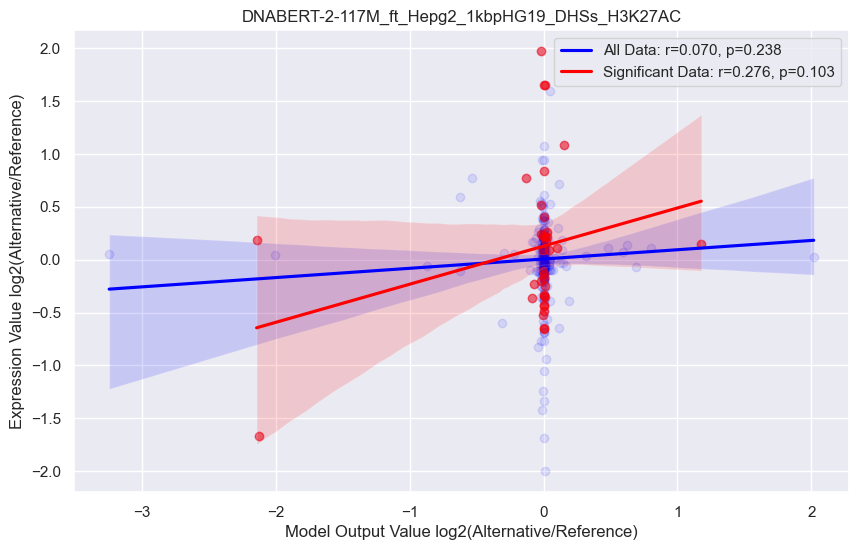

done


/tmp/ipykernel_1415579/2163299114.py:10: RuntimeWarning: invalid value encountered in log2
  log2_variant_expression_effect = np.log2(fold_change)


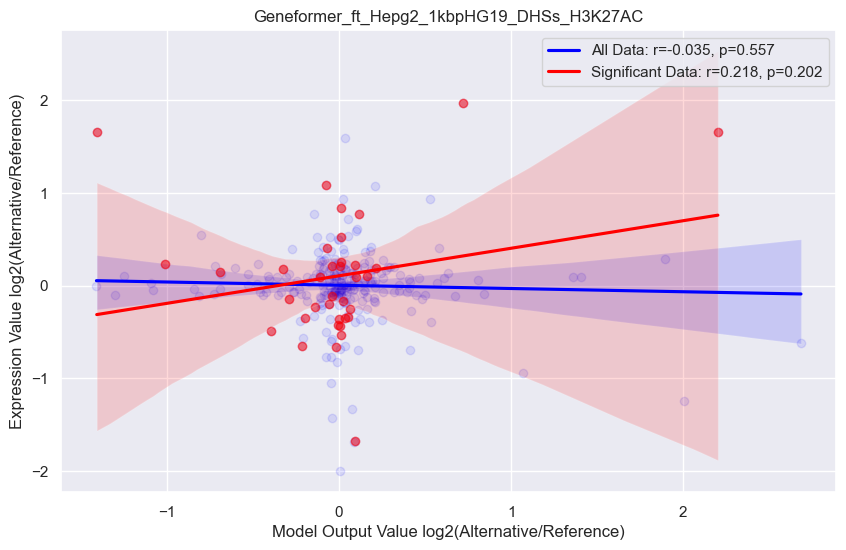

done


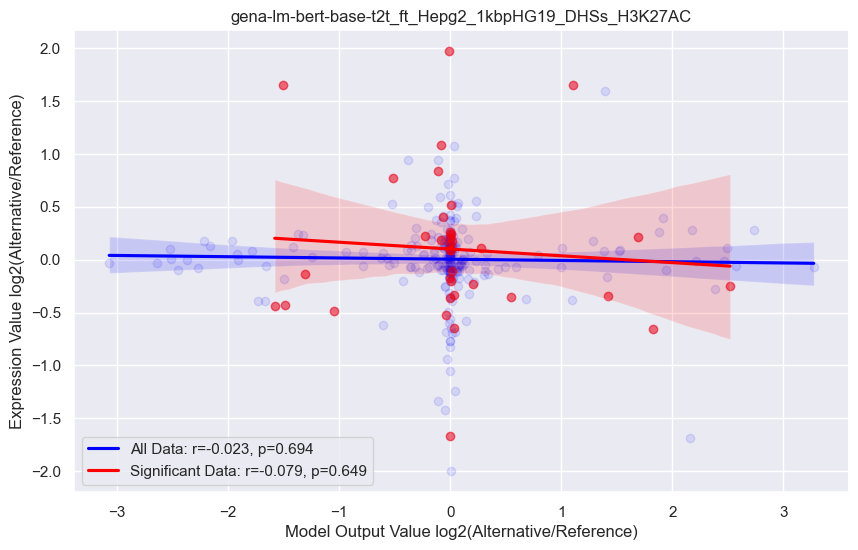

done


/tmp/ipykernel_1415579/2163299114.py:10: RuntimeWarning: invalid value encountered in log2
  log2_variant_expression_effect = np.log2(fold_change)


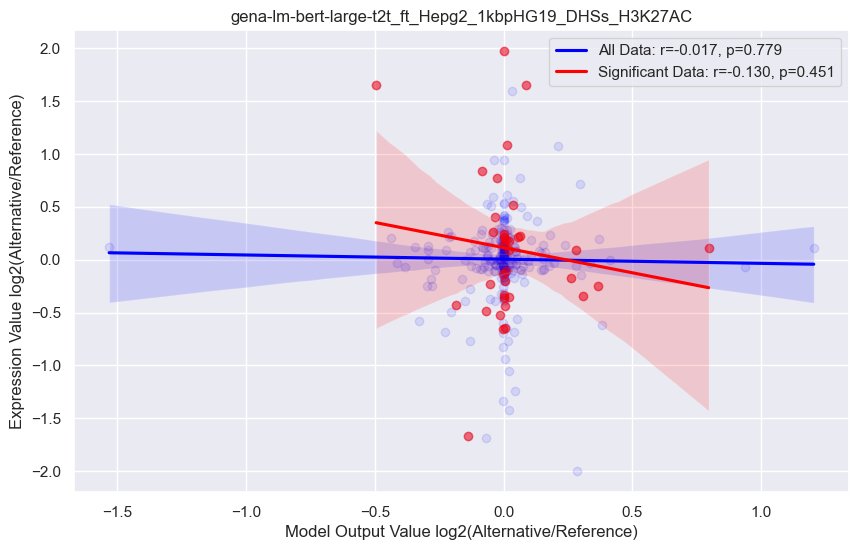

done


/tmp/ipykernel_1415579/2163299114.py:10: RuntimeWarning: invalid value encountered in log2
  log2_variant_expression_effect = np.log2(fold_change)


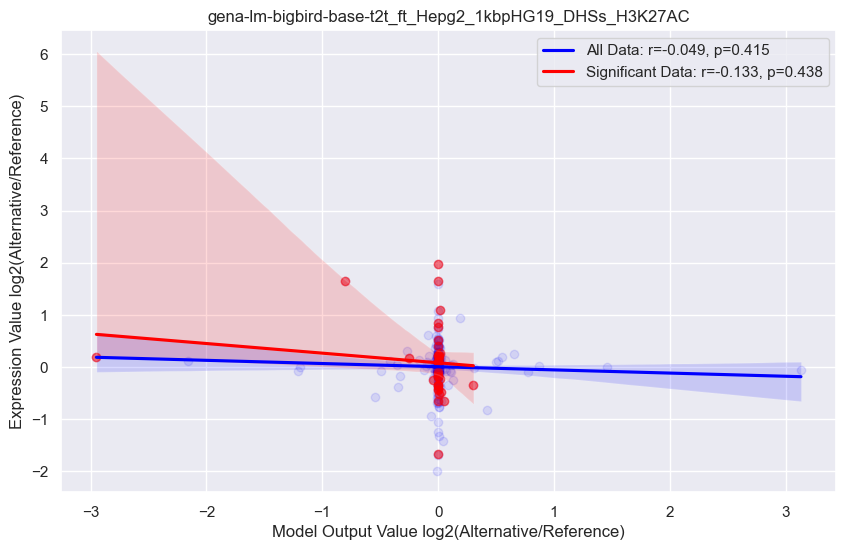

done


/tmp/ipykernel_1415579/2163299114.py:10: RuntimeWarning: invalid value encountered in log2
  log2_variant_expression_effect = np.log2(fold_change)


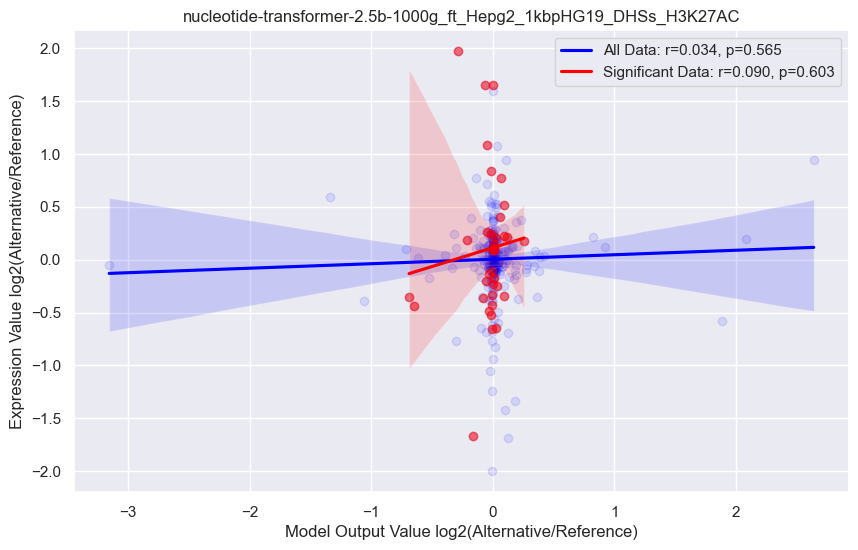

done


/tmp/ipykernel_1415579/2163299114.py:10: RuntimeWarning: invalid value encountered in log2
  log2_variant_expression_effect = np.log2(fold_change)


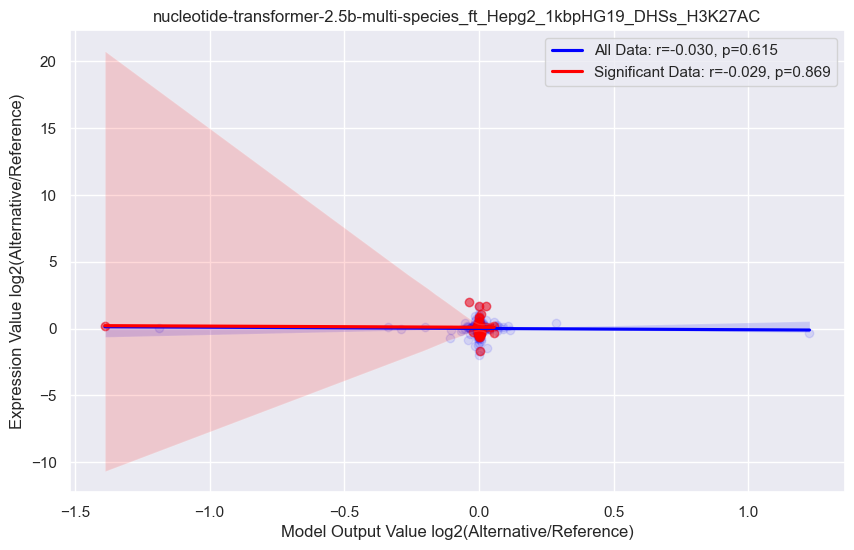

done


/tmp/ipykernel_1415579/2163299114.py:10: RuntimeWarning: invalid value encountered in log2
  log2_variant_expression_effect = np.log2(fold_change)


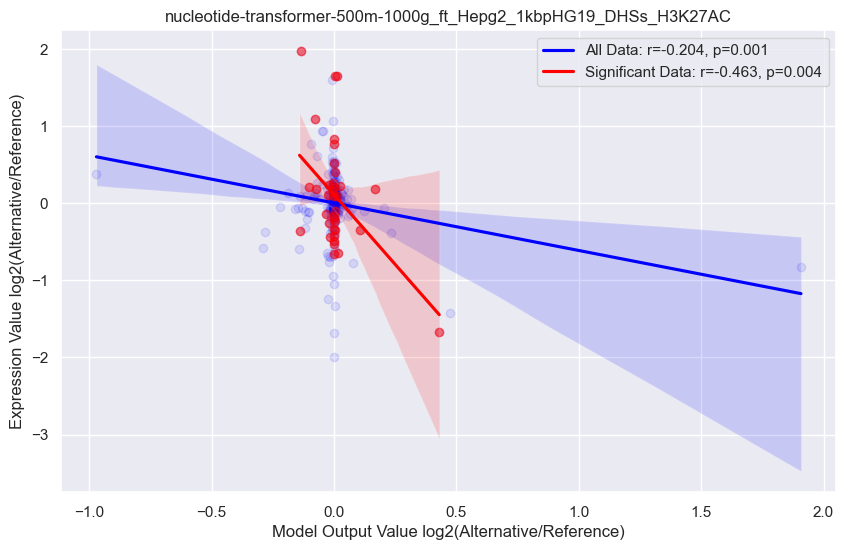

done


/tmp/ipykernel_1415579/2163299114.py:10: RuntimeWarning: invalid value encountered in log2
  log2_variant_expression_effect = np.log2(fold_change)


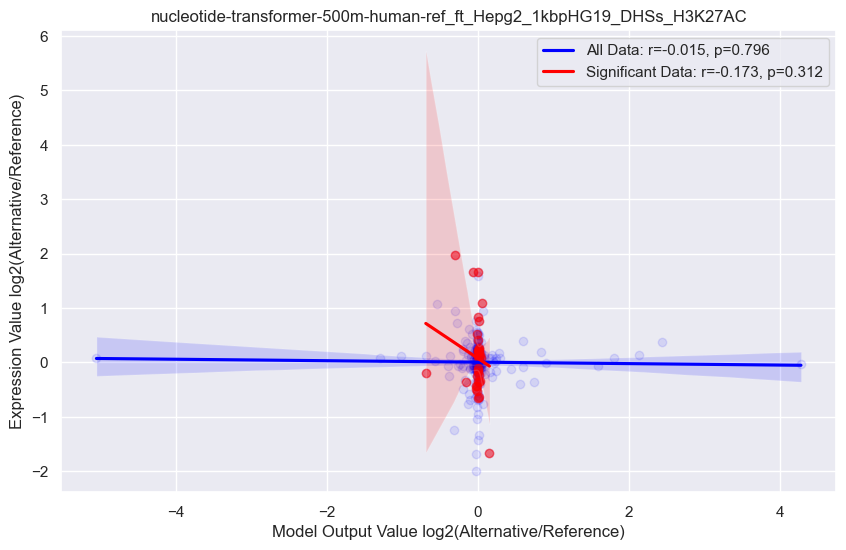

done


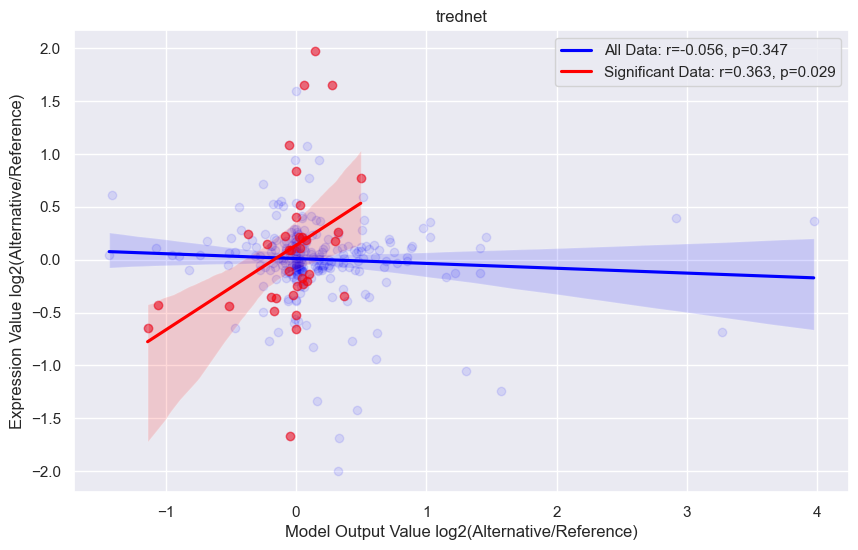

done


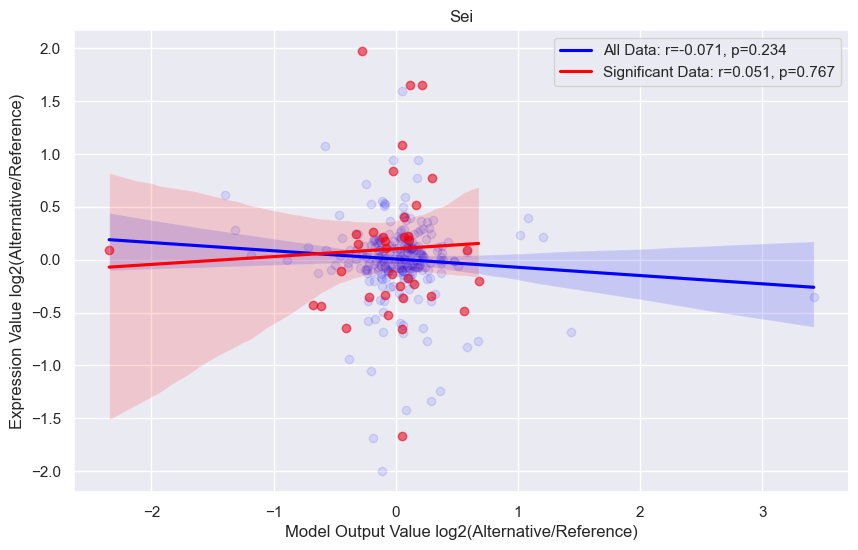

done


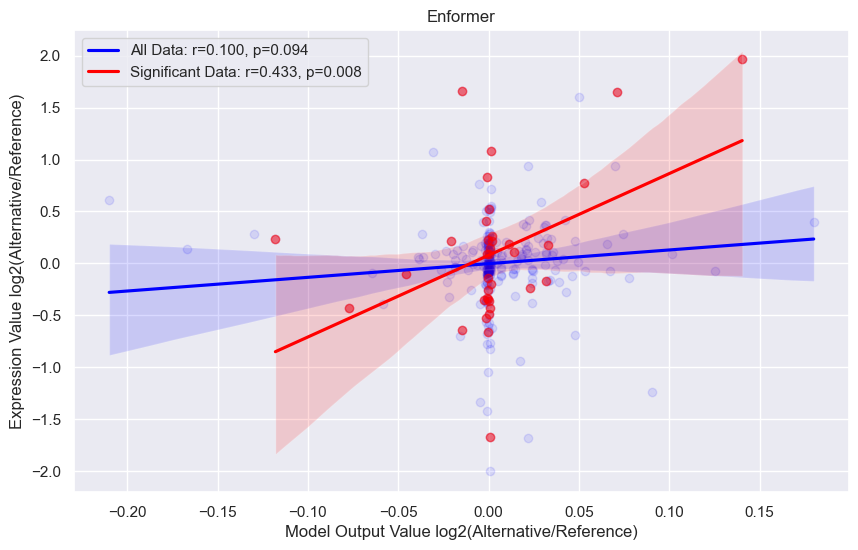

done


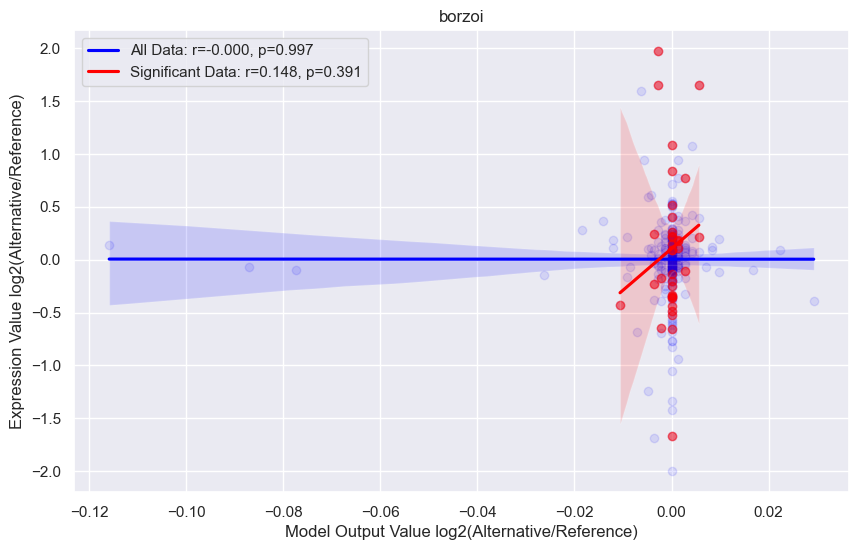

done


In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple, Any, Dict

def plot_regression(df_significant, df_all, model, r_val_significant, p_val_significant, r_val_all, p_val_all):
    plt.figure(figsize=(10, 6))
    
    # Plot non-significant data (all data)
    sns.regplot(
        x='Model Output Difference',
        y='Expression Difference',
        data=df_all,
        scatter_kws={'alpha': 0.1, 'color': 'blue'},
        line_kws={'color': 'blue', 'label': f'All Data: r={r_val_all:.3f}, p={p_val_all:.3f}'}
    )
    
    # Plot significant data
    sns.regplot(
        x='Model Output Difference',
        y='Expression Difference',
        data=df_significant,
        scatter_kws={'alpha': 0.5, 'color': 'red'},
        line_kws={'color': 'red', 'label': f'Significant Data: r={r_val_significant:.3f}, p={p_val_significant:.3f}'}
    )
    
    plt.ylabel('Expression Value log2(Alternative/Reference)')
    plt.xlabel('Model Output Value log2(Alternative/Reference)')
    plt.title(f'{model}')
    plt.legend()
    plt.show()

def process_models(models_names, models_predictions, seq_val):
    for model in models_names:
        # Fetch the model statistics and deltas for significant data
        (slope_significant, intercept_significant, r_val_significant, p_val_significant, std_err_significant, spearman_corr_significant), (delta_exp_significant, delta_model_out_significant) = get_linregress_stats(model, models_predictions[model], seq_val, True, filter_significant)
        
        # Fetch the model statistics and deltas for all data (non-significant included)
        (slope_all, intercept_all, r_val_all, p_val_all, std_err_all, spearman_corr_all), (delta_exp_all, delta_model_out_all) = get_linregress_stats(model, models_predictions[model], seq_val, False, filter_significant)
        
        # Prepare data for plotting
        df_significant = pd.DataFrame({
            'Expression Difference': delta_exp_significant,
            'Model Output Difference': delta_model_out_significant
        })
        
        df_all = pd.DataFrame({
            'Expression Difference': delta_exp_all,
            'Model Output Difference': delta_model_out_all
        })

        # Plot the regression with overlapping data
        plot_regression(df_significant, df_all, model, r_val_significant, p_val_significant, r_val_all, p_val_all)
        print('done')

# Call the process_models function with your parameters
process_models(models_names, models_predictions, np.log2(seq_val))
